In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
from PIL import Image
from sklearn.metrics import classification_report
import torch.utils.data
from torch.utils.data import DataLoader, Dataset, random_split, Subset
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms.functional as Func
import timm
import cv2
import math

In [2]:
# Set flags True to include Test set and GAN set
include_test_set = True
include_gan_set = False

# Load dataframes
train_csv = pd.read_csv("/kaggle/input/fetalhcdata/training_set/training_set_circumference.csv")
if include_test_set:
    test_csv = pd.read_csv("/kaggle/input/fetalhcdata/test_set/test_set_circumference.csv")
if include_gan_set:
    gan_csv = pd.read_csv("/kaggle/input/fetalhcdata/gan_set/measured_circumference.csv")
    #gan_csv_new = pd.read_csv("/kaggle/input/fetalhcdata/gan_set_without_masks/measured_circumference.csv")

# Add 'dataset' column
train_csv['dataset'] = 'train'
if include_test_set:
    test_csv['dataset'] = 'test'
if include_gan_set:
    gan_csv['dataset'] = 'gan'
    #gan_csv_new['dataset'] = 'gan_new'

# Concatenate the dataframes
dfs_to_concat = [train_csv]
if include_test_set:
    dfs_to_concat.append(test_csv)
if include_gan_set:
    dfs_to_concat.append(gan_csv)
    #dfs_to_concat.append(gan_csv_new)

In [3]:
## Concatenate the dataframes
merged_df = pd.concat(dfs_to_concat)

# Select classification based on one type of diameter or non to classify head circumference.
classify_ofd = False
classify_bpd = False

# Define parameters based on classification type
if classify_ofd:
    column_name = 'OFD'
    lowest_value_cm, highest_value_cm, limit_per_class = 3, 16, 375
    gan_samples_limit, oversample_limit = 1000, 0
elif classify_bpd:
    column_name = 'BPD'
    lowest_value_cm, highest_value_cm, limit_per_class = 2, 14, 410
    gan_samples_limit, oversample_limit = 1000, 0
else:
    column_name = 'Head_Circumference_mm'
    lowest_value_cm, highest_value_cm, limit_per_class = 6, 33, 230
    gan_samples_limit, oversample_limit = 1000, 0

# Calculate class based on the scale factor
merged_df['class'] = np.round(merged_df[column_name]/10)

# Generate the classes list
classes = list(range(lowest_value_cm, highest_value_cm + 1))

# Priority order
priority = ['gan_new', 'gan', 'test', 'train']

merged_df.loc[(merged_df['class'] <= lowest_value_cm), 'class'] = lowest_value_cm
merged_df.loc[(merged_df['class'] > highest_value_cm), 'class'] = highest_value_cm

In [4]:
# Extract 20% of samples from all datasets and 20% from 'train' dataset
extracted_samples_test = []
extracted_samples_train = []
extracted_samples_gan = []
for cir_class in classes:
    samples_in_class = merged_df[merged_df['class'] == cir_class]
    sample_count_gan = len(samples_in_class[samples_in_class['dataset'] == 'gan'])
    sample_count_train = len(samples_in_class[samples_in_class['dataset'] == 'train'])
    sample_count_test = len(samples_in_class[samples_in_class['dataset'] == 'test'])
    
    if sample_count_train > 1:
        extract_count_train = max(1, int(sample_count_train * 0.2))
        extracted_samples_train.append(samples_in_class[samples_in_class['dataset'] == 'train'].sample(n=extract_count_train, random_state=42))
    else:
        print(f"{cir_class}:{sample_count_train}")
        
    if sample_count_gan > 1:
        extract_count_gan = max(1, int(sample_count_gan * 0.2)) 
        extracted_samples_gan.append(samples_in_class[samples_in_class['dataset'] == 'gan'].sample(n=extract_count_gan, random_state=42))
        
    if sample_count_test > 1:
        extract_count_test = max(1, int(sample_count_test * 0.2))
        extracted_samples_test.append(samples_in_class[samples_in_class['dataset'] == 'test'].sample(n=extract_count_test, random_state=42))

# Combine the extracted samples into a single DataFrame
extracted_samples = extracted_samples_test + extracted_samples_train + extracted_samples_gan
if extracted_samples:
    extracted_df = pd.concat(extracted_samples)
    # Remove the extracted samples from the merged_df
    indices_to_keep = ~merged_df.set_index(['dataset', 'filename']).index.isin(extracted_df.set_index(['dataset', 'filename']).index)
    merged_df = merged_df.loc[indices_to_keep]
else:
    extracted_df = pd.DataFrame()

In [5]:
# Iterate over each class and limit the number of samples
for cir_class in classes:
    samples_in_class = merged_df[merged_df['class'] == cir_class]
    gan_samples_in_class = samples_in_class[(samples_in_class['dataset'] == 'gan')]
    
    if len(gan_samples_in_class) <= gan_samples_limit:
        continue
        
    samples_to_remove = len(gan_samples_in_class) - gan_samples_limit
    excess_samples = gan_samples_in_class.sample(n=samples_to_remove, random_state=42)
    indices_to_keep = ~merged_df.set_index(['dataset', 'filename']).index.isin(excess_samples.set_index(['dataset', 'filename']).index)
    merged_df = merged_df.loc[indices_to_keep]

In [6]:
for cir_class in classes:
    samples_in_class = merged_df[merged_df['class'] == cir_class]
    
    if len(samples_in_class) == 0:
        print(f"Class {cir_class - lowest_value_cm} has no samples")

    if len(samples_in_class) <= limit_per_class:
        continue

    excess_count = len(samples_in_class) - limit_per_class
    
    for dataset in priority:
        if excess_count <= 0:
            break
        dataset_samples = samples_in_class[(samples_in_class['dataset'] == dataset)]
        if len(dataset_samples) > 0:
            samples_to_remove = min(len(dataset_samples), excess_count)
            excess_samples = dataset_samples.sample(n=samples_to_remove, random_state=42)
            indices_to_keep = ~merged_df.set_index(['dataset', 'filename']).index.isin(excess_samples.set_index(['dataset', 'filename']).index)
            merged_df = merged_df.loc[indices_to_keep]
            excess_count -= samples_to_remove

# Oversample samples in each class until reaching limit_per_class amount of samples
for cir_class in classes:
    samples_in_class = merged_df[merged_df['class'] == cir_class]
    
    if len(samples_in_class) < oversample_limit:
        needed_samples = oversample_limit - len(samples_in_class)
        oversampled_samples = samples_in_class.sample(n=needed_samples, replace=True, random_state=42)
        merged_df = pd.concat([merged_df, oversampled_samples])

# Create a new merged_df with the filtered data
merged_df = merged_df.drop(columns=['class'])

val_df = pd.concat(extracted_samples_train)
val_df = val_df.drop(columns=['class'])

filtered_df = merged_df.copy()

# Display the filtered dataframe
filtered_df.head()

,filename,Head_Circumference_cm,Head_Circumference_mm,pixel size(mm),OFD,BPD,mask_filename,dataset
0,000_HC.png,4.430,44.30,0.069136,23.9,15.4,000_HC_Mask.png,train
1,001_HC.png,5.681,56.81,0.089659,25.7,23.3,001_HC_Mask.png,train
2,012_HC.png,5.940,59.40,0.083460,29.3,22.7,012_HC_Mask.png,train
3,004_HC.png,5.981,59.81,0.061240,30.7,21.6,004_HC_Mask.png,train
4,014_3HC.png,6.026,60.26,0.077308,28.1,24.1,014_3HC_Mask.png,train


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
workers = 4 if torch.cuda.is_available() else 0
print(device)

cuda


In [8]:
def filter_by_age_range(df, cir_cm_column_name, range_start, range_end, include=True):
    conditions = [
        (df[cir_cm_column_name] < 8.00),
        (df[cir_cm_column_name] >= 8.00) & (df[cir_cm_column_name] <= 9.00),  # week 13
        (df[cir_cm_column_name] > 9.00) & (df[cir_cm_column_name] <= 10.49),  # week 14
        (df[cir_cm_column_name] > 10.49) & (df[cir_cm_column_name] <= 12.49), # week 15
        (df[cir_cm_column_name] > 12.49) & (df[cir_cm_column_name] <= 13.49), # week 16
        (df[cir_cm_column_name] > 13.49) & (df[cir_cm_column_name] <= 14.99), # week 17
        (df[cir_cm_column_name] > 14.99) & (df[cir_cm_column_name] <= 16.49), # week 18
        (df[cir_cm_column_name] > 16.49) & (df[cir_cm_column_name] <= 17.49), # week 19
        (df[cir_cm_column_name] > 17.49) & (df[cir_cm_column_name] <= 18.99), # week 20
        (df[cir_cm_column_name] > 18.99) & (df[cir_cm_column_name] <= 19.99), # week 21
        (df[cir_cm_column_name] > 19.99) & (df[cir_cm_column_name] <= 20.99), # week 22
        (df[cir_cm_column_name] > 20.99) & (df[cir_cm_column_name] <= 22.49), # week 23
        (df[cir_cm_column_name] > 22.49) & (df[cir_cm_column_name] <= 22.99), # week 24
        (df[cir_cm_column_name] >= 23.00) & (df[cir_cm_column_name] <= 23.99),# week 25
        (df[cir_cm_column_name] > 23.99) & (df[cir_cm_column_name] <= 24.79), # week 26
        (df[cir_cm_column_name] > 24.79) & (df[cir_cm_column_name] <= 25.60), # week 27
        (df[cir_cm_column_name] > 25.60) & (df[cir_cm_column_name] <= 26.75), # week 28
        (df[cir_cm_column_name] > 26.75) & (df[cir_cm_column_name] <= 27.75), # week 29
        (df[cir_cm_column_name] > 27.75) & (df[cir_cm_column_name] <= 28.85), # week 30
        (df[cir_cm_column_name] > 28.85) & (df[cir_cm_column_name] <= 29.60), # week 31
        (df[cir_cm_column_name] > 29.60) & (df[cir_cm_column_name] <= 30.40), # week 32
        (df[cir_cm_column_name] > 30.40) & (df[cir_cm_column_name] <= 31.20), # week 33
        (df[cir_cm_column_name] > 31.20) & (df[cir_cm_column_name] <= 31.80), # week 34
        (df[cir_cm_column_name] > 31.80) & (df[cir_cm_column_name] <= 32.50), # week 35
        (df[cir_cm_column_name] > 32.50) & (df[cir_cm_column_name] <= 33.00), # week 36
        (df[cir_cm_column_name] > 33.00) & (df[cir_cm_column_name] <= 33.70), # week 37
        (df[cir_cm_column_name] > 33.70) & (df[cir_cm_column_name] <= 34.20), # week 38
        (df[cir_cm_column_name] > 34.20) & (df[cir_cm_column_name] <= 35.00), # week 39
        (df[cir_cm_column_name] > 35.00) & (df[cir_cm_column_name] <= 36.00), # week 40
        (df[cir_cm_column_name] > 36)
    ]

    values = [
        'Fetus is less than 8 Menstrual Weeks', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22',
        '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', 'Abnormal'
    ]
    
    # Create a new column 'Age' based on conditions and values
    df['Age'] = np.select(conditions, values, default='Unknown')

    # Forward fill 'Unknown' ages with the last known age
    df['Age'] = df['Age'].replace('Unknown', np.nan).ffill()

    # Filter the DataFrame to keep or exclude rows with ages within the specified range
    age_range = range(range_start, range_end + 1)  # +1 to include the end value in the range
    if include:
        filtered_df = df[df['Age'].isin(map(str, age_range))]
    else:
        filtered_df = df[~df['Age'].isin(map(str, age_range))]

    return filtered_df

#filtered_df = filter_by_age_range(merged_df.copy(), 'Head_Circumference_cm', 21, 40, include = False)
#val_df= filter_by_age_range(val_df.copy(), 'Head_Circumference_cm', 21, 40, include = False)

#print(filtered_df['Age'])

In [9]:
def classify_head_measurements(df, column_name):
    def round_classification(value):
        rounded_value = int(np.round(value/10))
        if rounded_value <= lowest_value_cm:
            return lowest_value_cm
        elif rounded_value > highest_value_cm:
            return highest_value_cm
        else:
            return rounded_value

    df['classes'] = df[column_name].apply(round_classification)
    
    # Normalize class labels to start from 0
    unique_classes = sorted(df['classes'].unique())
    class_mapping = {old_class: new_class for new_class, old_class in enumerate(unique_classes)}
    df['classes'] = df['classes'].map(class_mapping)
    
    num_classes = df['classes'].nunique()

    return num_classes, class_mapping

num_classes, class_mapping = classify_head_measurements(filtered_df, column_name)
classify_head_measurements(val_df, column_name)
balanced_df = filtered_df.copy()

print("Class Mapping:", class_mapping)
print("Number of Classes:", num_classes)

Class Mapping: {6: 0, 7: 1, 8: 2, 9: 3, 10: 4, 11: 5, 12: 6, 13: 7, 14: 8, 15: 9, 16: 10, 17: 11, 18: 12, 19: 13, 20: 14, 21: 15, 22: 16, 23: 17, 24: 18, 25: 19, 26: 20, 27: 21, 28: 22, 29: 23, 30: 24, 31: 25, 32: 26, 33: 27}
Number of Classes: 28


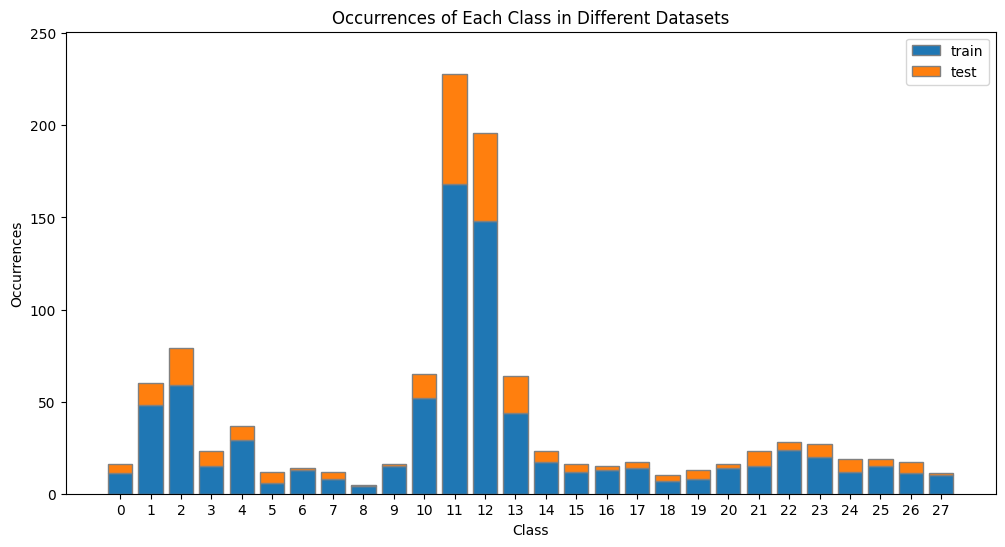

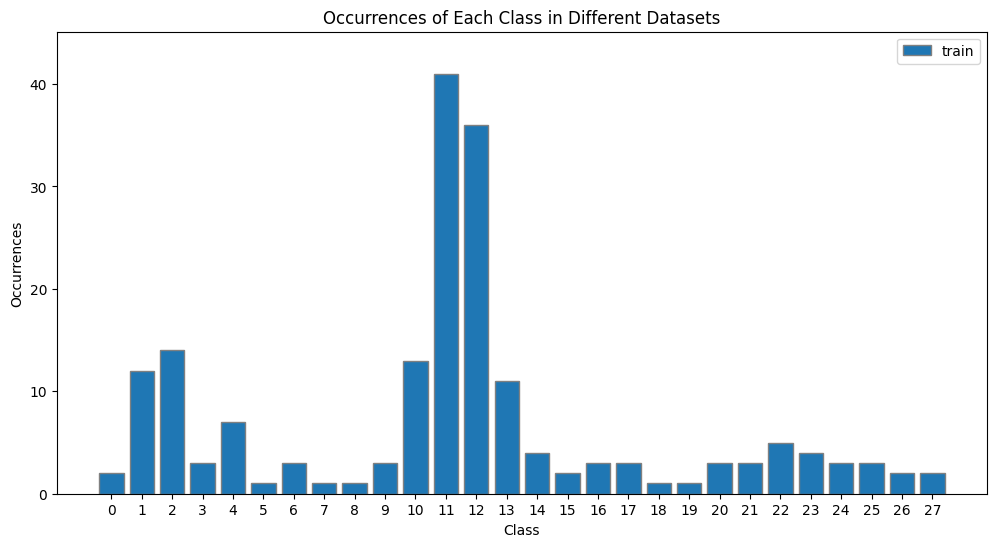

In [10]:
def plot_class_distribution(df, dataset_colors=None):
    # Make a copy of the DataFrame to avoid altering the original
    df_copy = df.copy()
    
    # Identify unique datasets in the 'dataset' column
    unique_datasets = df_copy['dataset'].unique()

    # Initialize a dictionary to hold class counts for each dataset
    class_counts_dict = {}

    # Loop through each unique dataset and count class occurrences
    for dataset in unique_datasets:
        dataset_data = df_copy[df_copy['dataset'] == dataset]
        class_counts = dataset_data['classes'].value_counts().sort_index()
        class_counts_dict[dataset] = class_counts

    # Combine the counts into a single DataFrame
    class_counts = pd.DataFrame(class_counts_dict).fillna(0)

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))

    # Default colors if dataset_colors is not provided
    default_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    if dataset_colors is None:
        dataset_colors = {}
    
    # Bar width
    bar_width = 0.35

    # Initialize bottom for stacked bars
    bottom = None

    for i, dataset in enumerate(class_counts.columns):
        if bottom is None:
            bottom = np.zeros_like(class_counts[dataset])

        # Get color for current dataset
        color = dataset_colors.get(dataset, default_colors[i % len(default_colors)])

        ax.bar(class_counts.index, class_counts[dataset], bottom=bottom, color=color, edgecolor='grey', label=dataset)
        bottom += class_counts[dataset]

    # Add labels
    ax.set_xlabel('Class')
    ax.set_ylabel('Occurrences')
    ax.set_title('Occurrences of Each Class in Different Datasets')
    ax.legend()

    # Set x-axis tick labels with class numbers
    ax.set_xticks(range(len(class_counts)))
    ax.set_xticklabels(class_counts.index)

    # Increase y-axis limit a little more than the top value
    max_count = class_counts.sum(axis=1).max()
    ax.set_ylim(0, max_count * 1.1)

    # Show plot
    plt.show()

dataset_colors = {'train': '#1f77b4', 'test': '#ff7f0e', 'gan': '#d62728', 'gan_new': '#9467bd'}
plot_class_distribution(balanced_df, dataset_colors)
plot_class_distribution(val_df, dataset_colors)

In [11]:
class NUDataset(torch.utils.data.Dataset):
  def __init__(self, df, img_paths, mask_paths, transform_X=None,transform_Y = None):
    self.X = [
            os.path.join(img_paths[dataset], filename) 
            for filename, dataset in zip(df['filename'], df['dataset'])
        ]
    self.Y = [
            os.path.join(mask_paths[dataset], mask_filename) 
            for mask_filename, dataset in zip(df['mask_filename'], df['dataset'])
        ]
    self.dataset = df['dataset'].tolist()
    self.transform_X = transform_X
    self.transform_Y = transform_Y

  def __len__(self):
      return len(self.X)

  def __getitem__(self,idx):
    X_path = self.X[idx]
    Y_path = self.Y[idx]
    
    image_name = os.path.basename(X_path)

    X = Image.open(X_path).convert("L")
    Y = Image.open(Y_path).convert("L")

    if self.transform_X is not None:
        X = self.transform_X(X)

    if self.transform_Y is not None:
        Y = self.transform_Y(Y)
        
    # Extract dataset type
    Dataset_type = self.dataset[idx]

    return X, Y, Dataset_type, image_name

In [12]:
img_size = 512

train_img_path='/kaggle/input/fetalhcdata/training_set/training_set'
test_img_path='/kaggle/input/fetalhcdata/test_set/test_set'
gan_img_path='/kaggle/input/fetalhcdata/gan_set/gan_images'
gan_new_img_path='/kaggle/input/fetalhcdata/gan_set/gan_images'

train_mask_path='/kaggle/input/fetalhcdata/training_set/images_mask'
test_mask_path='/kaggle/input/fetalhcdata/test_set/test_masks'
gan_mask_path='/kaggle/input/fetalhcdata/gan_set/gan_masks'
gan_new_mask_path='/kaggle/input/fetalhcdata/gan_set/gan_masks'

transform_X = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_Y = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor()
])

img_paths = {
    'train': train_img_path
}

mask_paths = {
    'train': train_mask_path
}

if include_test_set:
    img_paths['test'] = test_img_path
    mask_paths['test'] = test_mask_path
    
if include_gan_set:
    img_paths['gan'] = gan_img_path
    mask_paths['gan'] = gan_mask_path

unet_dataset = NUDataset(balanced_df, img_paths, mask_paths, transform_X, transform_Y)
unet_val = NUDataset(val_df, img_paths, mask_paths, transform_X, transform_Y)

In [13]:
print(len(unet_dataset))
print(len(unet_val))

1081
187


In [14]:
class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class NestedUNet(nn.Module):
    def __init__(self, n_channels, n_classes, deep_supervision=False):
        super(NestedUNet, self).__init__()
        self.deep_supervision = deep_supervision
        nb_filter = [32, 64, 128, 256, 512]

        self.conv0_0 = double_conv(n_channels, nb_filter[0])
        self.conv1_0 = double_conv(nb_filter[0], nb_filter[1])
        self.conv2_0 = double_conv(nb_filter[1], nb_filter[2])
        self.conv3_0 = double_conv(nb_filter[2], nb_filter[3])
        self.conv4_0 = double_conv(nb_filter[3], nb_filter[4])

        self.conv0_1 = double_conv(nb_filter[0]+nb_filter[1], nb_filter[0])
        self.conv1_1 = double_conv(nb_filter[1]+nb_filter[2], nb_filter[1])
        self.conv2_1 = double_conv(nb_filter[2]+nb_filter[3], nb_filter[2])
        self.conv3_1 = double_conv(nb_filter[3]+nb_filter[4], nb_filter[3])

        self.conv0_2 = double_conv(nb_filter[0]*2+nb_filter[1], nb_filter[0])
        self.conv1_2 = double_conv(nb_filter[1]*2+nb_filter[2], nb_filter[1])
        self.conv2_2 = double_conv(nb_filter[2]*2+nb_filter[3], nb_filter[2])

        self.conv0_3 = double_conv(nb_filter[0]*3+nb_filter[1], nb_filter[0])
        self.conv1_3 = double_conv(nb_filter[1]*3+nb_filter[2], nb_filter[1])

        self.conv0_4 = double_conv(nb_filter[0]*4+nb_filter[1], nb_filter[0])

        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        if self.deep_supervision:
            self.final1 = nn.Conv2d(nb_filter[0], n_classes, kernel_size=1)
            self.final2 = nn.Conv2d(nb_filter[0], n_classes, kernel_size=1)
            self.final3 = nn.Conv2d(nb_filter[0], n_classes, kernel_size=1)
            self.final4 = nn.Conv2d(nb_filter[0], n_classes, kernel_size=1)
        else:
            self.final = nn.Conv2d(nb_filter[0], n_classes, kernel_size=1)

        self.sigmoid = nn.Sigmoid()  # Sigmoid activation

    def forward(self, x):
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(F.max_pool2d(x0_0, 2))
        x2_0 = self.conv2_0(F.max_pool2d(x1_0, 2))
        x3_0 = self.conv3_0(F.max_pool2d(x2_0, 2))
        x4_0 = self.conv4_0(F.max_pool2d(x3_0, 2))

        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))

        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))

        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))

        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))

        if self.deep_supervision:
            output1 = self.sigmoid(self.final1(x0_1))
            output2 = self.sigmoid(self.final2(x0_2))
            output3 = self.sigmoid(self.final3(x0_3))
            output4 = self.sigmoid(self.final4(x0_4))
            return [output1, output2, output3, output4]

        else:
            output = self.sigmoid(self.final(x0_4))
            return output

In [15]:
# Define batch size
batch_size = 5

# Create data loaders
train_loader_unet = DataLoader(unet_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
val_loader_unet = DataLoader(unet_val, batch_size=batch_size, num_workers=workers)

In [16]:
def dice_coeff(y_pred, y_targets):
    smooth = 1
    num = y_targets.size(0)
    m1 = y_pred.view(num, -1)
    m2 = y_targets.view(num, -1)
    intersection = (m1 * m2)

    score = 2. * (intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
    score = score.sum() / num
    return score.item()


def dice_loss(y_predict, y_train):
    
    dice_loss = 1 -(dice_coeff(y_predict, y_train))
    return dice_loss

In [17]:
from torch.optim.lr_scheduler import CosineAnnealingLR

def train_and_validate(model, train_loader, validation_loader, criterion, optimizer, epochs=5, model_type = "classification", train_loss_threshold=None):
    train_running_loss_history = []
    validation_running_loss_history = []
    lr_history = []
    prev_val_loss = float('inf')
    early_stop = False
    
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

    for e in range(epochs):

        train_running_loss = 0.0
        validation_running_loss = 0.0
        
        if early_stop:
            break

        model.train()
        # Training loop
        for ith_batch, sample_batched in enumerate(train_loader):
            x_train, y_train = sample_batched[:2]
            X_train = x_train.to(device)
            
            if model_type == "classification":
                Y_train = F.one_hot(y_train, num_classes=num_classes).to(torch.float32).to(device)
            else:
                Y_train= y_train.to(device)

            optimizer.zero_grad()
            y_pred = model(X_train)

            # Calculate losses
            if model_type == "classification":
                loss = criterion(y_pred, Y_train)
            elif model_type == "segmentation":
                loss = 0.3 * dice_loss(y_pred, Y_train) + 0.7 * criterion(y_pred, Y_train)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            train_running_loss += loss.item()
        
        scheduler.step()
        lr_history.append(optimizer.param_groups[0]['lr'])

        # Validation loop
        with torch.no_grad():
            model.eval()
            for ith_batch, sample_batched in enumerate(validation_loader):
                x_val, y_val = sample_batched[:2]
                X_val = x_val.to(device)

                if model_type == "classification":
                    Y_val = F.one_hot(y_val, num_classes=num_classes).to(torch.float32).to(device)
                else:
                    Y_val = y_val.to(device)

                pred_val = model(X_val)
                
                # Calculate losses
                if model_type == "classification":
                    val_loss = criterion(pred_val, Y_val)
                elif model_type == "segmentation":
                    val_loss = 0.3 * dice_loss(pred_val, Y_val) + 0.7 * criterion(pred_val, Y_val)
                
                validation_running_loss += val_loss.item()

            train_epoch_loss = train_running_loss / len(train_loader)
            validation_epoch_loss = validation_running_loss / len(validation_loader)

            train_running_loss_history.append(train_epoch_loss)
            validation_running_loss_history.append(validation_epoch_loss)
            
            print("================================================================================")
            print(f"Epoch {e + 1} completed")
            print(f"Average train loss: {train_epoch_loss}")
            print(f"Average validation loss: {validation_epoch_loss}")
            print("================================================================================")
            
            if train_loss_threshold is not None:
                if train_epoch_loss < train_loss_threshold and validation_epoch_loss >= prev_val_loss:
                    print("Stopping training as training loss is below threshold and validation loss has stopped decreasing.")
                    early_stop = True
                prev_val_loss = validation_epoch_loss

        torch.cuda.empty_cache()

    # Plot loss history
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(train_running_loss_history, label='Train Loss')
    plt.plot(validation_running_loss_history, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    
    # Plot learning rate
    plt.subplot(1, 2, 2)
    plt.plot(lr_history, label='Learning Rate')
    plt.xlabel('Step')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.legend()

    plt.tight_layout()
    plt.show()

Epoch 1 completed
Average train loss: 0.33611515645057927
Average validation loss: 0.27225880285626963
Epoch 2 completed
Average train loss: 0.20248190687823406
Average validation loss: 0.19052384499656527
Epoch 3 completed
Average train loss: 0.13285591357177304
Average validation loss: 0.12276619359066612
Epoch 4 completed
Average train loss: 0.09910912549097417
Average validation loss: 0.10226273791570413
Epoch 5 completed
Average train loss: 0.07904000971723811
Average validation loss: 0.08093378869326491


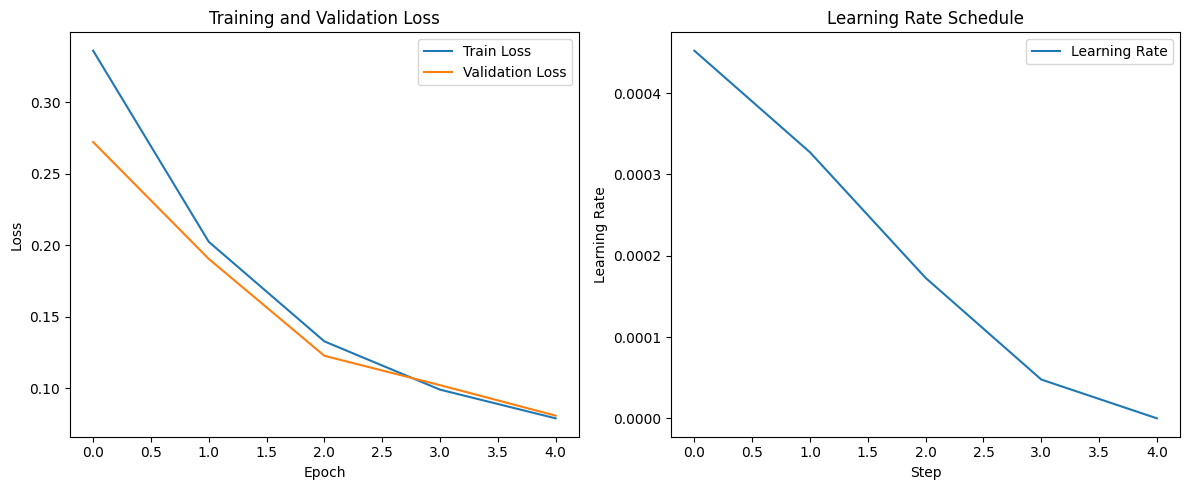

In [18]:
epochs = 5
learning_rate = 0.0005
weight_decay = 0.01

criterion = nn.BCELoss()

unet_model = NestedUNet(n_channels=1, n_classes=1)

# Use DataParallel for multi-GPU training
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(unet_model)

unet_model.to(device)

optimizer = optim.AdamW(unet_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

train_and_validate(unet_model, train_loader_unet, val_loader_unet, criterion, optimizer, epochs, "segmentation", 0.015)

In [19]:
use_head_zone = True

# Define paths for saving predictions
train_predictions_dir = '/kaggle/working/train/'
val_predictions_dir = '/kaggle/working/validate/'

# Create directories if they do not exist
os.makedirs(train_predictions_dir, exist_ok=True)
os.makedirs(val_predictions_dir, exist_ok=True)

def test_ellipse(imgray):
    ret, thresh = cv2.threshold(imgray, 127, 255, 0)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None
    largest_contour = max(contours, key=cv2.contourArea)
    if len(largest_contour) < 5:
        return None
    ellipse = cv2.fitEllipse(largest_contour)
    return ellipse

# Function to run inference and save predictions
def save_predictions(loader, model, output_dir):
    single_batch_validation_loader = DataLoader(loader.dataset, batch_size=1, shuffle=False, num_workers=workers)
    
    model.eval()
    with torch.no_grad():
        for batch_idx, batch in enumerate(single_batch_validation_loader):
            image, _, dataset, image_name = batch
            
            x = image.to(device)
            
            # Get prediction mask
            pred_mask = model(x)
            pred_mask = (pred_mask > 0.5).float().cpu().squeeze().numpy()
            
            # Apply the ellipse fitting function
            ellipse = test_ellipse((pred_mask * 255).astype(np.uint8))
            im_mask = np.zeros_like((pred_mask * 255).astype(np.uint8))
            
            if ellipse is not None:
                im_mask = cv2.ellipse(im_mask, ellipse, (255, 255, 255), -1)
            
            if use_head_zone:
                # Convert original image to numpy array
                original_image = image.cpu().squeeze().numpy()
                
                original_image = (original_image - original_image.min()) / (original_image.max() - original_image.min()) * 255

                # Apply the mask to the original image
                original_image[im_mask == 0] = 0
                
                # Convert image to uint8
                original_image = original_image.astype(np.uint8)
                
                # Save the modified image
                image_filepath = os.path.join(output_dir, f"{image_name[0]}_{dataset[0]}")
                cv2.imwrite(image_filepath, original_image)
            else:
                # Save the mask
                mask_filepath = os.path.join(output_dir, f"{image_name[0]}_{dataset[0]}")
                cv2.imwrite(mask_filepath, im_mask)
            

# Save predictions for training and validation sets
save_predictions(train_loader_unet, unet_model, train_predictions_dir)
save_predictions(val_loader_unet, unet_model, val_predictions_dir)

In [20]:
class FHCDataset(Dataset):
    def __init__(self, df, transform_X, images_dir):
        self.X = [os.path.join(images_dir, f"{filename}_{dataset}") for filename, dataset in zip(df['filename'], df['dataset'])]
        self.Y = df['classes'].astype(int).tolist()
        self.dataset = df['dataset'].tolist()
        self.transform_X = transform_X

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
         # Extract the image in grayscale
        img_path = self.X[idx]
        image_name = os.path.basename(img_path)
        img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Convert the processed image to PIL Image
        img_gray_np = Image.fromarray(img_gray)

        # Normalize and turn to tensor
        tensor_img = self.transform_X(img_gray_np)

        # Extract class label
        class_label = self.Y[idx]

        # Extract dataset type
        dataset_type = self.dataset[idx]

        return tensor_img, class_label, dataset_type, image_name

In [21]:
img_size = 512

# Define the transform pipeline including the noise addition
transform_X = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

In [22]:
train_dataset = FHCDataset(balanced_df, transform_X, train_predictions_dir)
val_dataset = FHCDataset(val_df, transform_X, val_predictions_dir)

In [23]:
print(len(train_dataset))
print(len(val_dataset))

1081
187


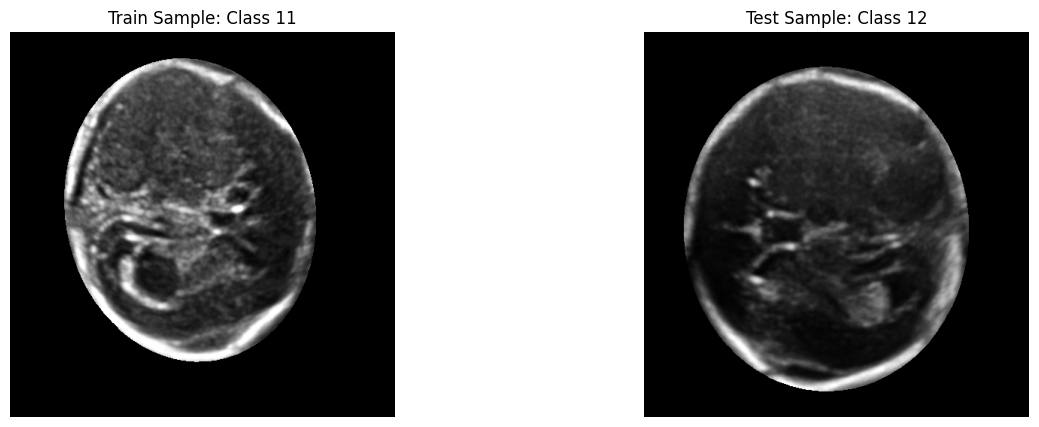

In [24]:
# Get the unique dataset types from the balanced_df
unique_dataset_types = balanced_df['dataset'].unique()

# Dictionary to hold one sample from each dataset type
samples = {}

# Get indices to iterate over in random order
indices = np.arange(len(train_dataset))
np.random.shuffle(indices)

# Create a subplot with a single row
plt.figure(figsize=(15, 5))

# Counter to keep track of the current position in the subplot
pos = 1

# Iterate through the shuffled indices
for idx in indices:
    batch = train_dataset[idx]
    img, label, dataset_type = batch[:3]
    if dataset_type not in samples:
        samples[dataset_type] = (img, label)
        # Plot the sample
        plt.subplot(1, len(unique_dataset_types), pos)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title(f'{dataset_type.capitalize()} Sample: Class {label}')
        plt.axis('off')
        pos += 1
    
    # If all dataset types are found, exit the loop
    if len(samples) == len(unique_dataset_types):
        break

plt.show()

In [25]:
# Define batch size
batch_size = 5

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=workers)

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Epoch 1 completed
Average train loss: 2.5674664298510224
Average validation loss: 2.226667195558548
Epoch 2 completed
Average train loss: 2.1892695580759356
Average validation loss: 2.1841149455622624
Epoch 3 completed
Average train loss: 2.0038442238135272
Average validation loss: 2.144115010374471
Epoch 4 completed
Average train loss: 1.9266782795778616
Average validation loss: 2.092932756009855
Epoch 5 completed
Average train loss: 1.8446588763443557
Average validation loss: 2.065452763908788
Epoch 6 completed
Average train loss: 1.80217471402911
Average validation loss: 2.033991294471841


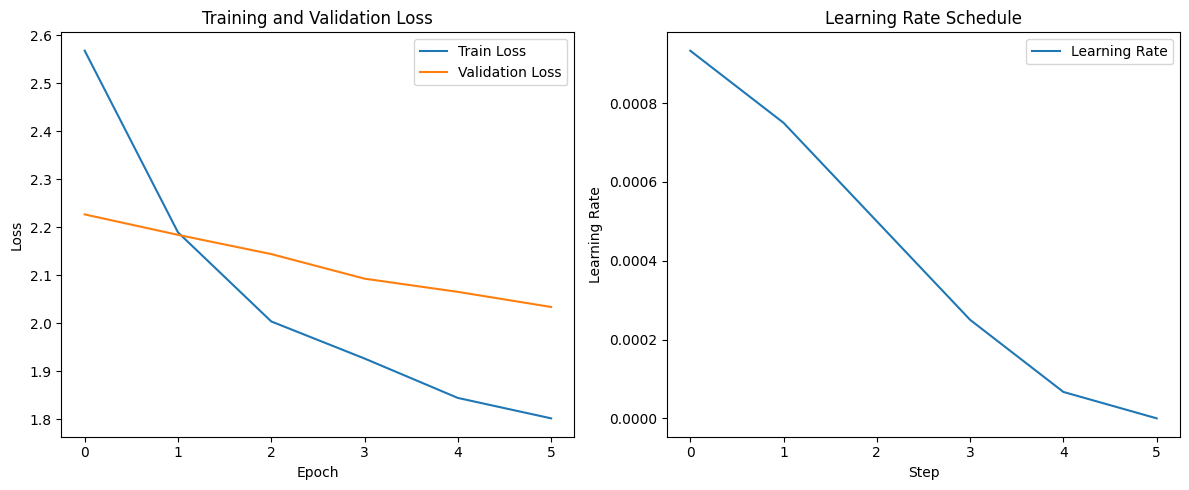

Epoch 1 completed
Average train loss: 1.8165043120010658
Average validation loss: 1.8563365889222998
Epoch 2 completed
Average train loss: 1.4583663849786679
Average validation loss: 1.7637348622083664
Epoch 3 completed
Average train loss: 1.182399124319103
Average validation loss: 1.8262045720690174
Epoch 4 completed
Average train loss: 0.8858565208824
Average validation loss: 1.8939634655651294
Stopping training as training loss is below threshold and validation loss has stopped decreasing.


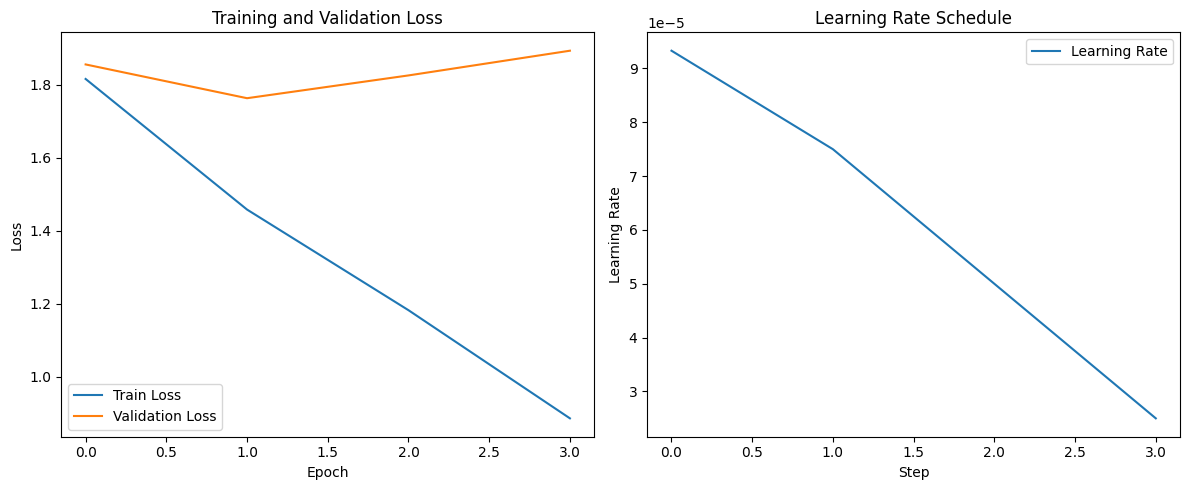

In [35]:
# Define your hyperparameters
classifier_epochs = 6
full_epochs = 6
learning_rate = 0.0001
weight_decay = 0.01

# Define loss function
criterion = nn.CrossEntropyLoss()

# Load pre-trained model
model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=num_classes, in_chans=1)

# Reset the parameters of the classifier
model.classifier = nn.Linear(model.classifier.in_features, num_classes)

# Freeze all layers except the classifier
for param in model.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True
    
# Optimizer for training the classifier
classifier_opt = optim.AdamW(model.classifier.parameters(), lr=learning_rate * 10)

# Use DataParallel for multi-GPU training if available
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

model.to(device)

# Train and validate classifier
train_and_validate(model, train_loader, val_loader, criterion, classifier_opt, classifier_epochs, "classification")

# Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

# Adjust optimizer to include only unfrozen parameters
full_opt = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Train and validate the entire model
train_and_validate(model, train_loader, val_loader, criterion, full_opt, full_epochs, "classification", 1)

In [36]:
from collections import defaultdict
from sklearn.metrics import classification_report, f1_score, accuracy_score

def evaluate_F1(validation_data):
    # Create a DataLoader with a specified batch size
    single_batch_validation_loader = DataLoader(validation_data, batch_size=1, shuffle=False, num_workers=workers)

    with torch.no_grad():
        model.eval()

        actual_values = []
        predicted_values = []

        # Iterate over batches
        for batch in single_batch_validation_loader:
            X_val, y_val = batch[:2]
            X_val = X_val.to(device).to(torch.float32)

            # Forward pass
            y_pred = model(X_val)

            actual_value = y_val.cpu().numpy()
            predicted_value = np.argmax(y_pred.cpu().numpy(), axis=1)

            actual_values.extend(actual_value)
            predicted_values.extend(predicted_value)

    # Calculate classification report
    report = classification_report(actual_values, np.array(predicted_values), output_dict=True, zero_division=1)

    print("Classification Report:")
    print(classification_report(actual_values, np.array(predicted_values), zero_division=1))

    # Calculate final F1 score and Accuracy
    final_f1_score = f1_score(actual_values, predicted_values, average='weighted')
    final_accuracy = accuracy_score(actual_values, predicted_values)

    print(f"\nFinal F1 Score (Weighted): {final_f1_score:.4f}")
    print(f"Final Accuracy: {final_accuracy:.4f}")

    # Find the three classes with the lowest F1 scores
    f1_scores = {int(k): v['f1-score'] for k, v in report.items() if k.isdigit()}
    sorted_f1_scores = sorted(f1_scores.items(), key=lambda item: item[1])

    print("\nThree classes with the lowest F1 scores:")
    for class_label, score in sorted_f1_scores[:3]:
        print(f"Class {class_label}: F1 score = {score:.4f}")

    # Count the number of wrong predictions for each distance
    distance_counts = defaultdict(int)
    for actual, predicted in zip(actual_values, predicted_values):
        if actual != predicted:
            distance = abs(predicted - actual)
            distance_counts[distance] += 1

    print("\nNumber of wrong predictions for each distance:")
    for distance, count in sorted(distance_counts.items()):
        print(f"Distance {distance}: {count} wrong predictions")

In [37]:
# Evaluate only on the train dataset
evaluate_F1(val_loader.dataset)

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.46      0.50      0.48        12
           2       0.53      0.64      0.58        14
           3       0.00      0.00      0.00         3
           4       0.50      0.43      0.46         7
           5       1.00      0.00      0.00         1
           6       0.50      0.33      0.40         3
           7       0.00      0.00      0.00         1
           8       1.00      0.00      0.00         1
           9       1.00      0.00      0.00         3
          10       0.29      0.15      0.20        13
          11       0.36      0.46      0.40        41
          12       0.36      0.39      0.37        36
          13       0.11      0.09      0.10        11
          14       0.00      0.00      0.00         4
          15       0.00      0.00      0.00         2
          16       1.00      0.33      0.50         3
    